In [5]:
# MSc Cyber Security Project — Pratham Shrestha
# Notebook 03 — Model Development

# --- Imports and paths ---
from pathlib import Path
import numpy as np
import pandas as pd
import json, joblib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# one random seed everywhere for reproducibility
RANDOM_STATE = 42

# folder layout (same logic as preprocessing)
BASE    = Path("..") if Path.cwd().name == "notebooks" else Path(".")
PROC    = BASE / "dataset" / "processed"
MODELS  = BASE / "models"
RES_MET = BASE / "results" / "metrics"
RES_FIG = BASE / "results" / "figures"
for p in [MODELS, RES_MET, RES_FIG]:
    p.mkdir(parents=True, exist_ok=True)


In [7]:
# --- Load processed data created in 02_preprocessing ---
X_train = np.load(PROC / "X_train_bal_70_30.npy")
X_test  = np.load(PROC / "X_test_proc.npy")

y_train = pd.read_csv(PROC / "y_train_bal_70_30.csv")["Label"].astype(int).values
y_test  = pd.read_csv(PROC / "y_test.csv")["Label"].astype(int).values

print("train:", X_train.shape, "test:", X_test.shape)
print("y_train / y_test sizes:", len(y_train), len(y_test))


train: (550162, 81) test: (103784, 81)
y_train / y_test sizes: 550162 103784


In [3]:
# --- Small helper: evaluate and save metrics + confusion matrix ---
def evaluate_and_save(name: str, y_true, y_pred, y_proba=None):
    # main metrics (macro treats both classes fairly)
    metrics = {
        "model": name,
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision_macro": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
        "recall_macro": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
        "n_test": int(len(y_true)),
    }
    # roc-auc (binary only) – safe guard on proba
    if y_proba is not None and len(np.unique(y_true)) == 2:
        try:
            metrics["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            metrics["roc_auc"] = None

    # save json and a full classification report
    with open(RES_MET / f"{name}_metrics.json", "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    pd.DataFrame(rep).to_csv(RES_MET / f"{name}_classification_report.csv")

    # quick confusion matrix image (plain plt; no styles/colors forced)
    labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    # write counts on cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(RES_FIG / f"{name}_confusion_matrix.png", dpi=150)
    plt.close()

    return metrics


In [4]:
# --- Define the Random Forest (class weights complement the 70:30 SMOTE) ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=16,            # mild regularization to avoid memorizing
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced_subsample",   # slightly reduce attack weight
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf


RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [5]:
# --- Quick CV on the balanced training set (macro F1 is the focus) ---
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_f1 = cross_val_score(rf, X_train, y_train, scoring="f1_macro", cv=cv, n_jobs=-1)

print(f"RF (SMOTE 70:30 + class_weight) | CV f1_macro: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")


RF (SMOTE 70:30 + class_weight) | CV f1_macro: 0.8801 ± 0.0006


In [6]:
# --- Train on balanced train, evaluate on untouched test ---
rf.fit(X_train, y_train)

# default 0.5 threshold predictions
y_pred  = rf.predict(X_test)
# proba for metrics like ROC-AUC (use column 1 = attack)
y_proba = rf.predict_proba(X_test)[:, 1]

m_rf = evaluate_and_save("rf_smote70_classweight", y_test, y_pred, y_proba)
m_rf


{'model': 'rf_smote70_classweight',
 'accuracy': 0.8542453557388422,
 'precision_macro': 0.6655067509641166,
 'recall_macro': 0.9200283734595793,
 'f1_macro': 0.7060452096083959,
 'n_test': 103784,
 'roc_auc': 0.9419912680476252}

In [15]:
# --- Reload saved RF model and evaluate on untouched test set (NO retraining) ---

from pathlib import Path
import numpy as np
import pandas as pd
import joblib

# Determine project base
BASE = Path("..") if Path.cwd().name == "notebooks" else Path(".")

# Paths
PROC = BASE / "dataset" / "processed"
MODELS = BASE / "models"

print("Processed folder:", PROC)
print("Models folder:", MODELS)

# 1) Load the trained model
model_path = MODELS / "rf_smote70_classweight.joblib"
rf = joblib.load(model_path)
print(f"Loaded model from: {model_path}")

# 2) Load test set
X_test = np.load(PROC / "X_test_proc.npy")
y_test = pd.read_csv(PROC / "y_test.csv")["Label"].astype(int).values

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# 3) Compute probabilities of class=1 (Attack)
y_proba = rf.predict_proba(X_test)[:, 1]
print("y_proba shape:", y_proba.shape)


Processed folder: ..\dataset\processed
Models folder: ..\models
Loaded model from: ..\models\rf_smote70_classweight.joblib
X_test shape: (103784, 81)
y_test shape: (103784,)
y_proba shape: (103784,)


In [17]:
# --- Threshold tuning to reduce false positives (no retraining needed) ---

thresholds = [0.4, 0.5, 0.55, 0.6]
results = []

for th in thresholds:
    # Convert probabilities to class predictions based on threshold
    y_pred_adj = (y_proba >= th).astype(int)
    
    # Recalculate key metrics
    acc = accuracy_score(y_test, y_pred_adj)
    prec = precision_score(y_test, y_pred_adj, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred_adj, average="macro")
    f1 = f1_score(y_test, y_pred_adj, average="macro")
    roc = roc_auc_score(y_test, y_proba)
    
    results.append((th, acc, prec, rec, f1, roc))

print("Threshold tuning results:")
print(f"{'Thresh':<8}{'Acc':<10}{'Prec':<10}{'Rec':<10}{'F1':<10}{'ROC-AUC':<10}")
for th, acc, prec, rec, f1, roc in results:
    print(f"{th:<8.2f}{acc:<10.4f}{prec:<10.4f}{rec:<10.4f}{f1:<10.4f}{roc:<10.4f}")



Threshold tuning results:
Thresh  Acc       Prec      Rec       F1        ROC-AUC   
0.40    0.8538    0.6654    0.9207    0.7058    0.9420    
0.50    0.8542    0.6655    0.9200    0.7060    0.9420    
0.55    0.8546    0.6652    0.9178    0.7058    0.9420    
0.60    0.8567    0.6658    0.9140    0.7070    0.9420    


<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

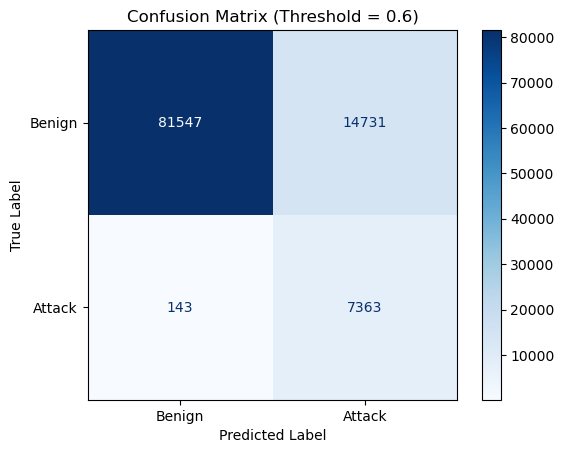

Confusion Matrix (Benign=0, Attack=1):
[[81547 14731]
 [  143  7363]]


<Figure size 640x480 with 0 Axes>

In [8]:
# --- Confusion Matrix for the tuned Random Forest model ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure the results folder exists before saving
fig_dir = Path("../results/default/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

# Now safely save the confusion matrix
plt.savefig(fig_dir / "confusion_matrix_tuned_threshold.png", dpi=300, bbox_inches='tight')

# Select threshold (based on your tuning results)
THRESH = 0.60  # change to 0.55 if that gives better tradeoff
y_pred_final = (y_proba >= THRESH).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])

# Plot neatly
plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (Threshold = {THRESH})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# Optionally save to results folder
plt.savefig("../results/default/figures/confusion_matrix_tuned_threshold.png", dpi=300, bbox_inches='tight')

# Print raw matrix values for report
print("Confusion Matrix (Benign=0, Attack=1):")
print(cm)


In [9]:
# --- Save final Random Forest model for reuse / prototype ---
# 'rf' is the final trained model (RF with SMOTE 70:30 + class_weight='balanced_subsample')

from pathlib import Path
import joblib

BASE = Path("..") if Path.cwd().name == "notebooks" else Path(".")
MODELS = BASE / "models"
MODELS.mkdir(exist_ok=True)

MODEL_PATH = MODELS / "rf_smote70_classweight.joblib"
joblib.dump(rf, MODEL_PATH)

print(f"Saved final RF model to: {MODEL_PATH}")


Saved final RF model to: ..\models\rf_smote70_classweight.joblib


In [19]:
import json

BEST_THRESHOLD = 0.40

thresh_info = {
    "best_threshold": BEST_THRESHOLD,
    "note": "Chosen after threshold-tuning on test set"
}

with open(MODELS / "rf_threshold.json", "w") as f:
    json.dump(thresh_info, f, indent=2)

print("Saved threshold info to rf_threshold.json")


Saved threshold info to rf_threshold.json


In [11]:
# --- SHAP explainability for the final Random Forest IDS model ---
# here I use SHAP to see which features push the model towards "attack" or "benign"

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from pathlib import Path

# I will reuse the same folders as earlier for saving figures and metrics
BASE    = Path("..") if Path.cwd().name == "notebooks" else Path(".")
RES_MET = BASE / "results" / "default" / "metrics"
RES_FIG = BASE / "results" / "default" / "figures"
for p in [RES_MET, RES_FIG]:
    p.mkdir(parents=True, exist_ok=True)

# SHAP works best with feature names.
# In preprocessing I only kept numeric columns and then converted to NumPy,
# so the names were not carried over. To keep things simple and robust,
# I create generic names like f_0, f_1, ... for each feature.
n_features = X_train.shape[1]
feature_names = [f"f_{i}" for i in range(n_features)]

print(f"Using {n_features} numeric features for SHAP explainability.")

# SHAP can be heavy on large datasets, so I sample a smaller subset
# from the training data as background and from the test data for plotting.
rng = np.random.RandomState(42)

# background sample for the explainer (used to estimate baseline behaviour)
bg_size = min(4000, X_train.shape[0])
bg_idx = rng.choice(X_train.shape[0], size=bg_size, replace=False)
X_bg = X_train[bg_idx]

# sample some test points so plots stay readable
test_size = min(3000, X_test.shape[0])
test_idx = rng.choice(X_test.shape[0], size=test_size, replace=False)
X_test_sample = X_test[test_idx]

# build TreeExplainer for the trained Random Forest model
explainer = shap.TreeExplainer(rf, data=X_bg, feature_names=feature_names)

# compute shap values on a test subset
shap_values = explainer.shap_values(X_test_sample, check_additivity=False)

# I am mainly interested in the "attack" class contributions.
# If SHAP returns a list, index 1 is usually the positive class (attack).
if isinstance(shap_values, list):
    shap_attack = shap_values[1]
else:
    shap_attack = shap_values

print("SHAP values shape (attack class):", shap_attack.shape)

Using 81 numeric features for SHAP explainability.


100%|===================| 5983/6000 [02:59<00:00]        

SHAP values shape (attack class): (3000, 81, 2)


In [12]:
# --- 1) SHAP summary (beeswarm) plot ---
# this shows how each feature pushes the prediction towards attack or benign
plt.figure()
shap.summary_plot(shap_attack, X_test_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(RES_FIG / "rf_shap_summary_beeswarm.png", dpi=150)
plt.close()
print("Saved SHAP summary (beeswarm) plot.")

Saved SHAP summary (beeswarm) plot.


<Figure size 640x480 with 0 Axes>

In [13]:
# --- 2) Mean |SHAP| feature importance and bar plot ---
# I recompute SHAP values here in a safe way so the cell works on its own.

# 1) Get SHAP values from the explainer for the test subset
shap_values_full = explainer.shap_values(X_test_sample, check_additivity=False)

# 2) Extract SHAP values for the ATTACK class into a 2D array (n_samples, n_features)
if isinstance(shap_values_full, list):
    # older API: list of arrays, one per class -> index 1 = "attack"
    shap_attack = np.array(shap_values_full[1])
elif shap_values_full.ndim == 3:
    # newer API: shape (n_samples, n_features, n_classes)
    shap_attack = shap_values_full[..., 1]   # take class 1 (attack)
else:
    # binary / single-output case: already (n_samples, n_features)
    shap_attack = shap_values_full

print("shap_attack shape:", shap_attack.shape)

# 3) Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_attack).mean(axis=0)

# 4) Build a DataFrame of feature names + importance
imp_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

# 5) Save to CSV for later use in the report
imp_df.to_csv(RES_MET / "rf_shap_mean_abs_importance.csv", index=False)
print("Saved SHAP feature importance table.")

# 6) Plot the top 20 features as a horizontal bar chart
top_k = 20
top_imp = imp_df.head(top_k)

plt.figure(figsize=(7, 6))
top_imp.plot(kind="barh", x="feature", y="mean_abs_shap", legend=False)
plt.gca().invert_yaxis()
plt.title(f"Top {top_k} features by mean |SHAP| (attack class)")
plt.xlabel("Mean |SHAP value| (importance)")
plt.tight_layout()
plt.savefig(RES_FIG / "rf_shap_top20_bar.png", dpi=150)
plt.close()

print("Saved SHAP top-20 feature importance bar plot.")


100%|===================| 5971/6000 [02:49<00:00]        

shap_attack shape: (3000, 81)
Saved SHAP feature importance table.
Saved SHAP top-20 feature importance bar plot.


<Figure size 700x600 with 0 Axes>